# Reconstruction of cellpainting image using ML

This notebook aims at showing basic models and training and generation for Cell-Painting data.

In [ ]:
import torchvision
import torch
import json
import os
import sys
import numpy as np 
import lightning as L

from lightning.pytorch.utilities.model_summary import ModelSummary
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.transforms import v2

plt.rcParams["savefig.bbox"] = 'tight'

# Adding the package in loading path
sys.path.extend(["../"])

import gencellpainting as gc
from gencellpainting.utils.dataset import WGANCriticDataset, CellPaintingDatasetInMemory
from gencellpainting.model import *


/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paths

We define the paths to the dataset and to store the trained models, the training tensorboard logs as well as the image for evaluations.

In [2]:
# Path of the data to update if you want to run this script
PATH_DATASET = "/mnt/c/Users/alexi/Documents/data/images/cellpainting/cpg0016-jump/data/jump_64px_uint8.pt"

PATH_ROOT = os.path.abspath("../..")

# Path of optimized parameters
PATH_OPTIM = os.path.join(PATH_ROOT,"data","optim")

# Path of the output of the model
PATH_OUTPUT = os.path.abspath(os.path.join(PATH_ROOT,"output"))
PATH_MODELS = os.path.join(PATH_OUTPUT,"models")
PATH_TSB_LOGS = os.path.join(PATH_OUTPUT,"tensorboard_logs")


### Parameters

High-levels parameters, which will be used during training:

In [3]:
BATCH_SIZE = 64
MAX_EPOCHS = 100
TEST_FRACTION = 0.2

### Loading the data

The data as already been preprocessed into tensor of dimension N, C, H, W where:
* __N__ is the number of example
* __C__ is the rnumber of channel: in this case 5
* __H__ is the heigth of the image in this case after resizing 64.
* __W__ is the wifdth of the image in this case after resizing 64.
This tensor is directly passed to the dataset we constructed. It could also be used directly with a _TensorDataset_.

In [4]:
ds = CellPaintingDatasetInMemory(tensor=torch.load(PATH_DATASET))

We save the image dimension to use as parameters when training the networks.

In [5]:
image = ds[1000]
C,H,W = image.shape

We can define some utility functions to visualize the images

[torch.Size([1, 64, 64]), torch.Size([1, 64, 64]), torch.Size([1, 64, 64]), torch.Size([1, 64, 64]), torch.Size([1, 64, 64])]


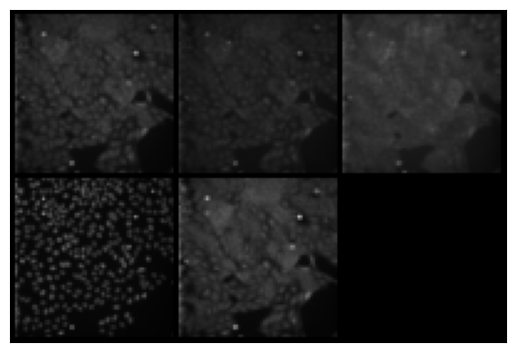

In [6]:
# Visualization function taken from  https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def plot_cellpainting_image(image, nrow=3):
    imgs = list(torch.split(image,1,dim=0))
    print([x.shape for x in imgs])
    grid = torchvision.utils.make_grid(imgs,nrow = nrow)
    show(grid)

plot_cellpainting_image(image)

In order to diversify the amount of image, we add a set of transformations

In [7]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True) # Tensor values [0, 255] -> [0.0, 1.0]
])
# We pass it directly to the datasets transfroms for convenience.
ds.transform = transforms

We can split the dataset into a train and test set

In [8]:
ds_train, ds_test = torch.utils.data.random_split(ds, [1-TEST_FRACTION,TEST_FRACTION])

No in order to perform the learning we need to create batches using a _DataLoader_.

In [9]:
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)

### Logging

We log the training using tensorboard, storing some diagnosis metrics as well as sampling some images at each trainig steps. You can run tensorboard `tensorboard --logdir {PATH_TSB_LOGS}` using the path defined at the beginning of this notebook.

In [10]:
# We erase the logs if they exists
if os.path.exists(PATH_TSB_LOGS):
    shutil.rmtree(PATH_TSB_LOGS)
print("Logging for tensorboard in '{}'".format(PATH_TSB_LOGS))


Logging for tensorboard in '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/output/tensorboard_logs'


# Training

We first retrieve the best parameters sets after the grid search for the VAE and WGAN-GP.

In [88]:
def load_best_params(model_name):
    OPTIM_NAME = model_name + "_hpar_optim"
    json_path = os.path.join(PATH_OPTIM,OPTIM_NAME,"best_parameters_"+OPTIM_NAME+".json")
    with open(json_path,"r") as f:
        params = json.load(f)
    return params

params_VAE = load_best_params("VAE")
params_WGANGP = load_best_params("WGANGP")



## $\beta$-VAE 
We first train the $\beta$-VAE using the optimized parameters. We update the monitoring parameters to output images during training at every epoch.

In [89]:
print(params_VAE)

{'in_channels': 5, 'out_channels': 5, 'epoch_monitoring_interval': 1, 'image_size': 64, 'learning_rate': 0.0005, 'alpha': 1e-05, 'latent_dim': 512, 'n_images_monitoring': 6, 'encoder_network_capacity': 8, 'decoder_network_capacity': 16, 'encoder_nlayers': 3, 'decoder_nlayers': 5}


In [41]:
model_vae = VAE(**params_VAE)

A good practice is to evaluate if:

1. The model can actually run.
2. We don t have a

In [42]:
ModelSummary(model_vae)

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 2.1 M  | train
1 | decoder | Decoder            | 5.8 M  | train
-------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.480    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode

We configure the trainer, with an early stopping case

In [50]:
NAME_MODEL = "VAE"
plogs = os.path.join(PATH_TSB_LOGS,NAME_MODEL)
# Deleting the model log folder if it already exists for clarity
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_TSB_LOGS, name=NAME_MODEL)


In [51]:
trainer = L.Trainer(max_epochs=100, accelerator="gpu", devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [52]:
trainer.fit(model_vae, train_dataloaders=dl_train, val_dataloaders=dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 2.1 M  | train
1 | decoder | Decoder            | 5.8 M  | train
-------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.480    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 248/248 [00:12<00:00, 19.47it/s, v_num=0, MSE_train_step=0.00139, KL_train_step=0.0453, total_loss_train_step=0.0467, MSE_val=0.0015, KL_val=0.0459, total_loss_val=0.0474, MSE_train_epoch=0.00141, KL_train_epoch=0.0458, total_loss_train_epoch=0.0472] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 248/248 [00:13<00:00, 18.44it/s, v_num=0, MSE_train_step=0.00139, KL_train_step=0.0453, total_loss_train_step=0.0467, MSE_val=0.0015, KL_val=0.0459, total_loss_val=0.0474, MSE_train_epoch=0.00141, KL_train_epoch=0.0458, total_loss_train_epoch=0.0472]


We save the model after training

In [55]:
trainer.save_checkpoint(os.path.join(PATH_MODELS,NAME_MODEL))

### Wasserstein GAN

The Wasserstein GAN are a more stable version of GAN, and to be frank I am just curious of their performance. We first have to modify the dataset. A wasserstein GAN need _N_ samples to train the generator and _N x C_ sample to train the _C_ critics.

In [57]:
NCRITICS = 5
ds_W = WGANCriticDataset(ds,ncritic=NCRITICS)
ds_train_W, ds_test_W = torch.utils.data.random_split(ds_W, [1-TEST_FRACTION,TEST_FRACTION])

In order for the dataloader to know how to stitch a batch together we need to provide a specific `collate_fn` argument

In [58]:
# This function will return a tuple with 2 elements
# 1. The images to process with the generator (B x C x H x W)
# 2. The images to process with the discriminator for learning ( (B x NCRITIC) x C x H x W) 
def collate_wgan_batch(batch):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    return gen_imgs, disc_imgs

In [59]:
dl_train_W = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)
dl_test_W = torch.utils.data.DataLoader(ds_test_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)

We can now test the model

In [60]:
import gencellpainting.model.WGAN as WGAN
importlib.reload(WGAN)

<module 'gencellpainting.model.WGAN' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/WGAN.py'>

In [ ]:
print(params_WGANGP)

{'in_channels': 5, 'out_channels': 5, 'vlambda': 10, 'n_critic': 5, 'epoch_monitoring_interval': 1, 'image_size': 64, 'learning_rate': 0.0005, 'noise_dim': 128, 'n_images_monitoring': 3}


In [64]:
wgan = WGAN.WGAN_GP(**params_WGANGP)

In [92]:
ModelSummary(wgan)

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | precision     | BinaryPrecision | 0      | train
1 | recall        | BinaryRecall    | 0      | train
2 | generator     | Decoder         | 2.6 M  | train
3 | discriminator | WGANCritic      | 696 K  | train
----------------------------------------------------------
2.6 M     Trainable params
696 K     Non-trainable params
3.3 M     Total params
13.264    Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode

In [66]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_TSB_LOGS, name="WGAN_GP")
trainer_wg = L.Trainer(max_epochs=100,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [67]:
trainer_wg.fit(wgan,dl_train_W)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | precision     | BinaryPrecision | 0      | train
1 | recall        | BinaryRecall    | 0      | train
2 | generator     | Decoder         | 2.6 M  | train
3 | discriminator | WGANCritic      | 696 K  | train
----------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.264    Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 496/496 [01:14<00:00,  6.63it/s, v_num=0, total_loss_val=8.480, G_loss=8.480, C_loss=0.194, d_C_loss=9.830, d_G_loss=9.050, GradPen=0.185]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 496/496 [01:15<00:00,  6.60it/s, v_num=0, total_loss_val=8.480, G_loss=8.480, C_loss=0.194, d_C_loss=9.830, d_G_loss=9.050, GradPen=0.185]


In [68]:
trainer_wg.save_checkpoint(os.path.join(PATH_MODELS,"WGANGP"))

### Diffusion based model

This section presents the diffusion training process

In [69]:
import gencellpainting.model.net.UNETdiffusion as UND
importlib.reload(UND)
import gencellpainting.model.diffusion as DIF
importlib.reload(DIF)


<module 'gencellpainting.model.diffusion' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/diffusion.py'>

In [71]:
TIME_CHANNELS = 62
NETWORK_CAPACITY = 16
NSTEPS = 200
NLAYERS = 3

We can now create the diffusion process using the UNET created

In [72]:
diff_unet = UND.UNetDiffusionV2(ds.n_channels, ds.n_channels, time_channels = TIME_CHANNELS, network_capacity=NETWORK_CAPACITY, nlayers=NLAYERS)

diffusion = DIF.DiffusionProcess(1,time_dim=TIME_CHANNELS,nsteps=NSTEPS,\
                                 model=diff_unet, include_time_emb=True)

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [93]:
ModelSummary(diffusion)

  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | loss       | SmoothL1Loss    | 0      | train
1 | model      | UNetDiffusionV2 | 1.9 M  | train
2 | time_model | Sequential      | 6.0 K  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.664     Total estimated model params size (MB)
230       Modules in train mode
0         Modules in eval mode

This version of diffusion is suited to generate images with values in [-1,1], our current dataset have value between [0,1]. We can create a new dataloader to rescale the image

In [74]:
def collate_diff_batch(batch):
    gen_imgs = batch
    gen_imgs = torch.stack(gen_imgs)
    gen_imgs = gen_imgs * 2. - 1.
    return gen_imgs

In [75]:
dl_train_diff = torch.utils.data.DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True, collate_fn=collate_diff_batch, num_workers=4)


Showing the main parameters of the diffusion models

In [76]:
ModelSummary(diffusion)

  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | loss       | SmoothL1Loss    | 0      | train
1 | model      | UNetDiffusionV2 | 1.9 M  | train
2 | time_model | Sequential      | 6.0 K  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.664     Total estimated model params size (MB)
230       Modules in train mode
0         Modules in eval mode

We need to train the model

In [77]:

NAME_MODEL = "DIFFUNET"
plogs = os.path.join(PATH_TSB_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_TSB_LOGS, name=NAME_MODEL)

trainer_diff = L.Trainer(max_epochs=100,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [78]:
trainer_diff.fit(diffusion,dl_train_diff)

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params | Mode 
-------------------------------------------------------
0 | loss       | SmoothL1Loss    | 0      | train
1 | model      | UNetDiffusionV2 | 1.9 M  | train
2 | time_model | Sequential      | 6.0 K  | train
-------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.664     Total estimated model params size (MB)
230       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 248/248 [01:15<00:00,  3.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 248/248 [01:16<00:00,  3.26it/s, v_num=0]


In [80]:
trainer_diff.save_checkpoint(os.path.join(PATH_MODELS,NAME_MODEL))